In [2]:
import pandas as pd
import numpy as np
import os
import random
import tensorflow as tf
import pickle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.layers import BatchNormalization
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.metrics import classification_report
import lightgbm as lgb
from sklearn.feature_selection import mutual_info_classif


C:\Users\Adya2\AppData\Local\Temp\ipykernel_24128\789677073.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
clinical = pd.read_csv('clinical.csv', index_col = 0 )
#Read csv file in outer directory so that there is no change in the existing results and do not save but save as

In [4]:
clinical.head(5)

,index,PTID,RID,Phase,Group,PTGENDER_-4.0,PTGENDER_1.0,PTGENDER_2.0,PTHOME_-4.0,PTHOME_1.0,...,PHC_EXF,PHC_LAN,PTCOGBEG,AGE,PHC_VSP,PTDOBYY,PHC_MEM,VISDATE,PTDOB,PTADDX
0,0,002_S_0295,295,ADNI1,0.0,False,True,False,False,True,...,0.554,0.272,-4.0,84.9363,0.483,1921.0,1.357,2006-04-04,06/1921,-4.0
1,1,002_S_0413,413,ADNI1,0.0,False,False,True,False,True,...,1.480,2.594,-4.0,76.9528,-4.000,1929.0,1.287,2006-04-06,12/1929,-4.0
2,2,002_S_0559,559,ADNI1,0.0,False,True,False,False,True,...,1.176,1.041,-4.0,80.5284,-4.000,1927.0,0.768,2006-05-11,01/1927,-4.0
3,3,002_S_0619,619,ADNI1,2.0,False,True,False,False,False,...,-0.509,0.116,-4.0,78.0315,0.264,1928.0,-1.259,2006-05-18,12/1928,-4.0
4,4,002_S_0685,685,ADNI1,0.0,False,False,True,False,True,...,0.111,1.170,-4.0,92.7228,-4.000,1916.0,0.149,2006-06-22,11/1916,-4.0


In [5]:
boolean_cols = [col for col in clinical.columns if clinical[col].dtype == 'bool']

In [6]:
for i in boolean_cols:
  clinical[i] = clinical[i].astype(int)
X = clinical.drop(['Group','PTID','Phase', 'VISDATE','RID','index'], axis=1)
y = clinical['Group']

In [7]:
X['PTDOB'] = X['PTDOB'].astype(str)
#X = X.drop(X.index[2938])

In [8]:
X['PTDOB'] = X['PTDOB'].apply(lambda x: int(x[:2]))


In [9]:
X[boolean_cols].sum() #106 boolean cols ---> only 10 non-bool

PTGENDER_-4.0       0
PTGENDER_1.0     1128
PTGENDER_2.0     1104
PTHOME_-4.0         0
PTHOME_1.0       1707
                 ... 
PTTLANG_1.0      2199
PTTLANG_2.0        33
NXCONSCI_-4.0      16
NXCONSCI_1.0     2210
NXCONSCI_2.0        6
Length: 105, dtype: int64

In [9]:
#y=y.drop(y.index[-1])

In [10]:

def make_mi_scores(X, y):
    #X=X.drop(columns=['Subject'])
    mi_scores = mutual_info_classif(X, y)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y)
print(mi_scores[::])

PHC_MEM          0.503768
PTCOGBEG         0.323648
PTADDX           0.235206
PHC_LAN          0.226221
PHC_EXF          0.205060
                   ...   
NXNERVE_2.0      0.000000
NXPLANTA_1.0     0.000000
NXPLANTA_2.0     0.000000
PTMARRY_-4.0     0.000000
PTGENDER_-4.0    0.000000
Name: MI Scores, Length: 114, dtype: float64


In [12]:
features = list(mi_scores[:20:].index)

X=X.loc[:, features]

In [13]:

X_scaled = (X - X.mean(axis=0)) / X.std(axis=0)

In [35]:
#features = list(mi_scores[:20:].index)


In [40]:
#X=X.loc[:, features]

In [14]:
X_scaled.head()

,PHC_MEM,PTCOGBEG,PTADDX,PHC_LAN,PHC_EXF,PHC_VSP,NXTENDON_2.0,PTGENDER_2.0,AGE,NXVISUAL_1.0,NXCONSCI_2.0,NXVISUAL_-4.0,PTHAND_-4.0,NXTREMOR_1.0,NXTENDON_-4.0,PTHOME_-4.0,NXGAIT_-4.0,NXOTHER_2.0,NXPLANTA_-4.0,PTTLANG_2.0
0,1.342147,-0.978146,-1.331988,0.386929,0.588460,1.313698,-0.407517,-0.989083,1.532499,0.249646,-0.051906,-0.084953,-0.029941,0.365391,-0.090147,NaN,-0.084953,-0.224344,-0.141777,-0.122475
1,1.257840,-0.978146,-1.331988,1.628601,1.085774,-0.936509,-0.407517,1.010585,0.475165,0.249646,-0.051906,-0.084953,-0.029941,-2.735569,-0.090147,NaN,-0.084953,-0.224344,-0.141777,-0.122475
2,0.632764,-0.978146,-1.331988,0.798146,0.922509,-0.936509,-0.407517,-0.989083,0.948717,0.249646,-0.051906,-0.084953,-0.029941,0.365391,-0.090147,NaN,-0.084953,-0.224344,-0.141777,-0.122475
3,-1.808525,-0.978146,-1.331988,0.303509,0.017569,1.203773,-0.407517,-0.989083,0.618028,0.249646,-0.051906,-0.084953,-0.029941,0.365391,-0.090147,NaN,-0.084953,4.455437,-0.141777,-0.122475
4,-0.112750,-0.978146,-1.331988,0.867128,0.350544,-0.936509,-0.407517,1.010585,2.563742,0.249646,-0.051906,-0.084953,-0.029941,-2.735569,-0.090147,NaN,-0.084953,-0.224344,-0.141777,-0.122475


In [15]:
X_scaled.dropna(axis=1, inplace=True)

In [16]:
X_scaled

,PHC_MEM,PTCOGBEG,PTADDX,PHC_LAN,PHC_EXF,PHC_VSP,NXTENDON_2.0,PTGENDER_2.0,AGE,NXVISUAL_1.0,NXCONSCI_2.0,NXVISUAL_-4.0,PTHAND_-4.0,NXTREMOR_1.0,NXTENDON_-4.0,NXGAIT_-4.0,NXOTHER_2.0,NXPLANTA_-4.0,PTTLANG_2.0
0,1.342147,-0.978146,-1.331988,0.386929,0.588460,1.313698,-0.407517,-0.989083,1.532499,0.249646,-0.051906,-0.084953,-0.029941,0.365391,-0.090147,-0.084953,-0.224344,-0.141777,-0.122475
1,1.257840,-0.978146,-1.331988,1.628601,1.085774,-0.936509,-0.407517,1.010585,0.475165,0.249646,-0.051906,-0.084953,-0.029941,-2.735569,-0.090147,-0.084953,-0.224344,-0.141777,-0.122475
2,0.632764,-0.978146,-1.331988,0.798146,0.922509,-0.936509,-0.407517,-0.989083,0.948717,0.249646,-0.051906,-0.084953,-0.029941,0.365391,-0.090147,-0.084953,-0.224344,-0.141777,-0.122475
3,-1.808525,-0.978146,-1.331988,0.303509,0.017569,1.203773,-0.407517,-0.989083,0.618028,0.249646,-0.051906,-0.084953,-0.029941,0.365391,-0.090147,-0.084953,4.455437,-0.141777,-0.122475
4,-0.112750,-0.978146,-1.331988,0.867128,0.350544,-0.936509,-0.407517,1.010585,2.563742,0.249646,-0.051906,-0.084953,-0.029941,-2.735569,-0.090147,-0.084953,-0.224344,-0.141777,-0.122475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2227,-0.193444,1.446518,0.813980,0.326503,0.179223,0.778628,-0.407517,1.010585,0.872577,0.249646,-0.051906,-0.084953,-0.029941,-2.735569,-0.090147,-0.084953,4.455437,7.050177,-0.122475
2228,1.083204,1.446518,0.813980,0.926484,0.733465,-0.936509,2.452788,1.010585,0.156793,0.249646,-0.051906,-0.084953,-0.029941,0.365391,-0.090147,-0.084953,-0.224344,7.050177,-0.122475
2229,0.459333,1.446518,0.813980,-1.897490,-1.857294,-0.936509,2.452788,-0.989083,1.247859,0.249646,-0.051906,-0.084953,-0.029941,-2.735569,-0.090147,-0.084953,-0.224344,7.050177,-0.122475
2230,-1.019653,-0.488995,0.813980,0.162872,-0.167715,1.050681,-0.407517,1.010585,0.233303,0.249646,-0.051906,-0.084953,-0.029941,0.365391,-0.090147,-0.084953,-0.224344,7.050177,-0.122475


In [17]:
from sklearn.decomposition import PCA

# Create principal components
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
X_pca = pd.DataFrame(X_pca, columns=component_names)

X_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
0,-0.770569,-1.795769,-0.704237,-0.298823,-0.070293,0.612091,-0.548347,0.454063,0.342684,0.293667,0.378316,-0.558101,-0.494686,-0.065906,2.061160,-0.292019,-0.033139,-0.148656,-1.809770e-16
1,-0.328534,-1.277568,-1.466482,0.502768,0.494128,-0.428974,0.673616,-0.799487,-1.055636,1.563596,-1.688574,-0.311734,-2.389425,0.135006,0.178020,-0.049606,0.053201,0.393696,-2.927236e-16
2,-0.663819,-1.295387,-0.464862,-0.307156,0.357695,0.612665,-0.660085,0.479113,0.039347,1.088177,0.736485,0.280055,-1.522538,0.072187,0.339578,-0.022730,-0.014215,-0.068694,-1.730960e-16
3,-0.585333,-2.701526,1.245640,1.843878,-1.717556,-0.107609,0.866384,-1.071437,1.193222,1.622295,1.655577,1.073909,1.700696,-0.839251,0.189860,0.346160,-0.005908,0.150154,-2.006163e-17
4,-0.077044,-2.058518,0.095856,0.884738,0.148875,-0.183285,0.202972,-0.577484,-0.650233,1.401196,-1.372186,-2.057359,-2.381435,-0.047369,-0.328207,0.102378,0.058802,0.387489,2.529446e-16


In [18]:
loadings = pd.DataFrame(
    pca.components_.T,
    columns=component_names,
    index=X_scaled.columns,
)
loadings

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19
PHC_MEM,0.001072,0.359827,-0.389360,0.080056,0.070478,-0.001679,-0.038301,0.082303,-0.156810,0.169082,0.021889,0.018530,-0.263598,0.023218,0.729877,-0.206129,-0.004861,0.006753,5.091890e-18
PTCOGBEG,0.036229,0.484679,-0.211937,0.207516,-0.051583,0.039036,-0.014900,0.104569,0.207922,-0.118194,-0.039418,-0.187855,0.123804,-0.033639,-0.049528,0.739919,0.001828,-0.003383,3.791831e-18
PTADDX,0.073074,0.482489,-0.132886,0.189855,-0.064794,0.092312,-0.006305,0.109903,0.211397,-0.165021,-0.116566,-0.140856,0.226397,-0.124883,-0.337585,-0.629758,-0.004443,0.023345,5.789338e-17
PHC_LAN,-0.187430,-0.237548,-0.566755,0.035224,0.004257,0.006745,0.054099,0.041101,0.007637,0.053582,0.050989,0.082257,-0.089286,-0.015991,-0.238164,0.019281,0.013884,0.709577,-2.635904e-16
PHC_EXF,-0.185009,-0.223970,-0.572115,0.052852,0.009204,0.024139,0.030022,0.050047,0.008761,0.059479,0.046724,0.076953,-0.102293,-0.032902,-0.251430,-0.005362,-0.009977,-0.703432,1.789861e-16
PHC_VSP,-0.106292,-0.333798,-0.194058,-0.076486,-0.180630,-0.027985,0.133198,-0.072184,0.161752,-0.406878,-0.201935,-0.152993,0.570051,-0.053277,0.438243,-0.037083,-0.006091,-0.015671,4.017960e-17
NXTENDON_2.0,-0.015843,-0.075640,0.060471,0.542902,0.181065,-0.178102,-0.142385,0.131901,-0.423965,-0.597310,0.142400,0.183475,-0.052208,0.011334,-0.010437,0.002352,0.001199,0.003926,-2.724196e-16
PTGENDER_2.0,0.014430,0.175560,-0.122540,-0.165007,-0.140734,-0.477621,0.226078,-0.482285,-0.428661,-0.052387,0.059847,-0.426965,-0.040126,-0.002752,-0.143826,-0.012669,0.011765,-0.010523,-6.898878e-17
AGE,-0.012347,-0.303235,0.084498,0.266868,-0.114263,0.127489,-0.220183,0.192907,0.097070,0.073674,0.200887,-0.766557,-0.237718,-0.089496,0.061248,-0.057357,0.001042,0.012539,2.438584e-17
NXVISUAL_1.0,-0.216030,0.051032,0.074408,0.015968,-0.171540,0.045072,0.056458,-0.439630,0.471294,-0.396430,0.042347,0.128312,-0.541447,-0.141939,0.071530,-0.029043,-0.014529,0.001120,-2.054190e-16


array([<Axes: title={'center': '% Explained Variance'}, xlabel='Component'>,
       <Axes: title={'center': '% Cumulative Variance'}, xlabel='Component'>],
      dtype=object)

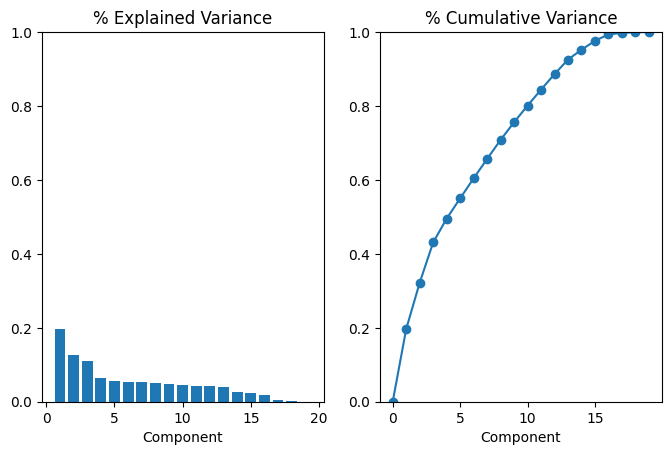

In [19]:
def plot_variance(pca, width=8, dpi=100):

    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)

    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    fig.set(figwidth=8, dpi=100)
    return axs

plot_variance(pca)

In [20]:
mi_scores = make_mi_scores(X_pca, y)
mi_scores

PC3     0.342918
PC2     0.225809
PC16    0.178584
PC1     0.087392
PC4     0.083147
PC15    0.068412
PC8     0.061617
PC17    0.052474
PC6     0.050752
PC9     0.046804
PC10    0.045558
PC5     0.034402
PC18    0.034258
PC14    0.032541
PC13    0.030431
PC12    0.024500
PC7     0.001509
PC11    0.000000
PC19    0.000000
Name: MI Scores, dtype: float64

# **Ignore**

In [26]:
sampling_strategy = {0: 400 , 1: 600, 2:276  }
rus = RandomUnderSampler(random_state=42, sampling_strategy=sampling_strategy)
X, y = rus.fit_resample(X,y)


# **Continue**

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


In [22]:
lgb_params = {
    'boosting_type':'gbdt',
    'num_leaves':31,
    'max_depth':3,
    'learning_rate':0.01,
    'n_estimators':200,
    'subsample_for_bin':3500, #can decrease this
    'min_child_weight':0.001,
    'min_child_samples':20,
    'subsample':0.6,
    'reg_alpha':0.05,
    'random_state':51
             }


m = lgb.LGBMClassifier(**lgb_params)
m.fit(X_train,y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000727 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1125
[LightGBM] [Info] Number of data points in the train set: 2008, number of used features: 14
[LightGBM] [Info] Start training from score -0.884674
[LightGBM] [Info] Start training from score -1.065309
[LightGBM] [Info] Start training from score -1.416630
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMClassifier(learning_rate=0.01, max_depth=3, n_estimators=200,
               random_state=51, reg_alpha=0.05, subsample=0.6,
               subsample_for_bin=3500)

In [23]:
from sklearn.metrics import classification_report

y_pred = m.predict(X_test)
y_pred


array([1., 0., 2., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1.,
       2., 2., 1., 2., 1., 2., 2., 2., 1., 1., 1., 2., 0., 0., 1., 0., 2.,
       1., 1., 1., 2., 0., 0., 1., 0., 0., 0., 0., 0., 2., 2., 0., 0., 1.,
       1., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1.,
       0., 2., 0., 0., 1., 1., 0., 1., 0., 1., 2., 0., 0., 2., 1., 0., 2.,
       2., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0.,
       0., 0., 1., 0., 2., 0., 1., 2., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 2., 0., 1., 2., 0., 0., 1., 0., 0., 2., 1., 0., 0., 1., 1.,
       1., 1., 1., 0., 1., 0., 1., 0., 0., 2., 2., 0., 2., 1., 0., 2., 0.,
       1., 2., 2., 1., 0., 2., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
       2., 2., 0., 1., 1., 0., 0., 1., 2., 0., 0., 1., 0., 2., 1., 1., 0.,
       2., 2., 1., 0., 0., 0., 1., 1., 1., 2., 0., 0., 0., 1., 2., 0., 0.,
       0., 0., 2., 0., 0., 1., 1., 2., 0., 0., 1., 0., 0., 0., 0., 2., 2.,
       1., 1., 0.])

In [24]:
report = classification_report(y_test, y_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.93      0.92       100
         1.0       0.86      0.83      0.85        83
         2.0       0.90      0.90      0.90        41

    accuracy                           0.89       224
   macro avg       0.89      0.89      0.89       224
weighted avg       0.89      0.89      0.89       224



In [30]:
m.booster_.save_model('lgbm_model.txt')


# **Deep Learning Approach**

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [83]:
obj_cols = [col for col in clinical.columns if clinical[col].dtype == 'object']
obj_cols

['PTID', 'Phase', 'VISDATE', 'PTDOB']

In [ ]:
X_train

In [92]:
model = Sequential()
model.add(Dense(128, input_shape = (115,), activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(32, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(3, activation = "softmax"))

model.compile(Adam(learning_rate = 0.0001), "sparse_categorical_crossentropy", metrics = ["sparse_categorical_accuracy"])

model.summary()

C:\Users\Adya2\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 128)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,179 (102.26 KB)

 Trainable params: 25,731 (100.51 KB)

 Non-trainable params: 448 (1.75 KB)

In [93]:
history = model.fit(X_train, y_train,  epochs=100, validation_split=0.1, batch_size=32,verbose=1)


Epoch 1/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 1.7119 - sparse_categorical_accuracy: 0.3500 - val_loss: 1.0183 - val_sparse_categorical_accuracy: 0.5698
Epoch 2/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3242 - sparse_categorical_accuracy: 0.4989 - val_loss: 0.7403 - val_sparse_categorical_accuracy: 0.7598
Epoch 3/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1405 - sparse_categorical_accuracy: 0.5767 - val_loss: 0.6828 - val_sparse_categorical_accuracy: 0.7598
Epoch 4/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.1466 - sparse_categorical_accuracy: 0.5941 - val_loss: 0.6621 - val_sparse_categorical_accuracy: 0.7598
Epoch 5/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0781 - sparse_categorical_accuracy: 0.6149 - val_loss: 0.6558 - val_sparse_categorical_accuracy: 0.7598
Epoch 6/100
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0036 - sparse_categorical_accuracy: 0.6126 - val_loss: 0.6620 - val_sparse_categorical_accuracy: 0.7598
Epoch 7/1

In [100]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


array([[0.12872367, 0.70439523, 0.16688111],
       [0.35153663, 0.2744154 , 0.37404794],
       [0.01495771, 0.03957061, 0.9454716 ],
       ...,
       [0.9682082 , 0.02708461, 0.00470721],
       [0.96810114, 0.0271911 , 0.00470779],
       [0.9682303 , 0.02708147, 0.00468826]], dtype=float32)

In [102]:
y_pred = np.argmax(y_pred, axis=1)


In [103]:
report = classification_report(y_test, y_pred)

print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.91      0.77      0.83       189
         1.0       0.80      0.67      0.73       168
         2.0       0.51      0.81      0.62        90

    accuracy                           0.74       447
   macro avg       0.74      0.75      0.73       447
weighted avg       0.78      0.74      0.75       447



In [99]:
model.save_model("DL_CLINICAL.h5")

AttributeError: 'Sequential' object has no attribute 'save_model'